# <font color="blue">1. Import Libraries</font>

* Import the required libraries.

In [1]:
# pip install lime

In [2]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm
from sklearn.metrics import log_loss, confusion_matrix, f1_score, roc_curve, auc, balanced_accuracy_score, matthews_corrcoef
from custom_package.response_encoder import ResponseEncoder
from custom_package.standardize import Standardize
from custom_package.merge_datasets import MergeDatasets
from custom_package.data_preprocessing import PreprocessData
from lime import lime_tabular
from shap import TreeExplainer

In [3]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

# <font color="blue">2. Merge Datasets</font>

In [4]:
# Dictionary containing the keys as the dataset name and its corresponding value containing the location of the dataset.
datasetLoc = {
    'Provider': 'Data/Test-1542969243754.csv',
    'Beneficiary': 'Data/Test_Beneficiarydata-1542969243754.csv',
    'Inpatient': 'Data/Test_Inpatientdata-1542969243754.csv',
    'Outpatient': 'Data/Test_Outpatientdata-1542969243754.csv'
}

In [5]:
%%time
# Read the Provider data, Beneficiary data, Inpatient and Outpatient claims data from the respective locations.
dataProviderTest = pd.read_csv(datasetLoc['Provider'])
dataBeneficiaryTest = pd.read_csv(datasetLoc['Beneficiary'])
dataInpatientTest = pd.read_csv(datasetLoc['Inpatient'])
dataOutpatientTest = pd.read_csv(datasetLoc['Outpatient'])

# Call the function 'MergeDatasets' to merge the datasets.
xTest = MergeDatasets(dataProviderTest, dataBeneficiaryTest, dataInpatientTest, dataOutpatientTest)

Wall time: 821 ms


In [6]:
%%time
# Call the PreprocessData function to do all the preprocessing of the data.
xTest = PreprocessData(xTest)

Wall time: 20.8 s


In [7]:
%%time
# Load the trained XGBoost Model
with open('Model/BestModel.pkl', 'rb') as f:
    model = pickle.load(f)

Wall time: 1.45 s


In [8]:
# Show the steps in the model
model.steps

[('standardization',
  Standardize(numericalFeatures=['Race', 'ClaimSettlementDelay',
                                 'TreatmentDuration', 'Age', 'TotalClaimAmount',
                                 'IPTotalAmount', 'OPTotalAmount',
                                 'UniquePhysCount', 'PhysRoleCount'])),
 ('responseEncoding',
  ResponseEncoder(categoricalFeatures=['State', 'Country'],
                  className='PotentialFraud')),
 ('xgboost',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.3,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                learning_rate=0.1, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=1000, n_jobs=24, num_parallel_tree=1,
                predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
       

# <font color="blue">3. Model Interpretability</font>

## <font color="blue">3.1. Model Interpretability - XGBoost's Feature Importance</font>

* Our trained model is XGBoost and XGBoost gives feature importance.
* With feature importance, we can justify the reason for classifying a claim record as fraudulent or not.
* Lets plot the feature importance learnt by the XGBoost Model

In [9]:
# Display XGBoost Model in the trained model pipeline
model.named_steps['xgboost']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=24, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

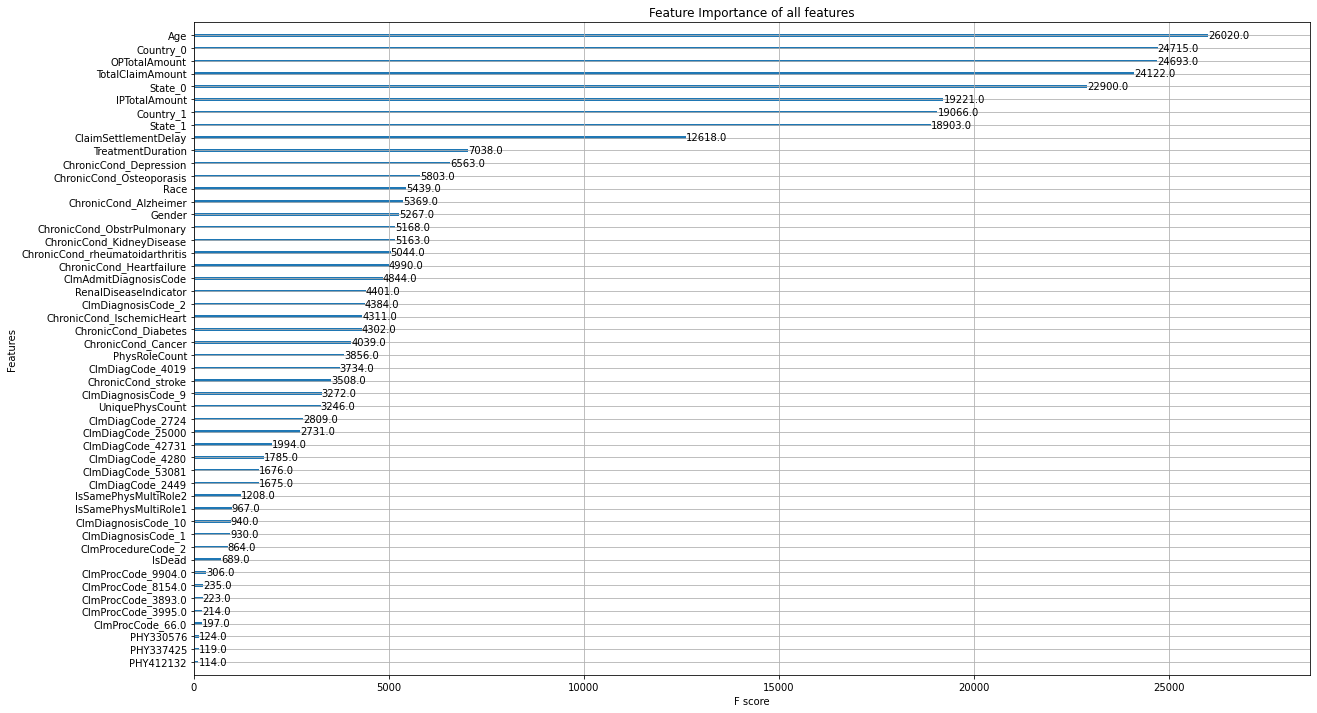

In [10]:
# Reference: 'Increase figsize in xgboost plot_importance' - https://stackoverflow.com/a/41719864/16007029
# Plot the Feature Importance of all the Features
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
xgb.plot_importance(model.named_steps['xgboost'], ax=ax, title='Feature Importance of all features')
plt.show()

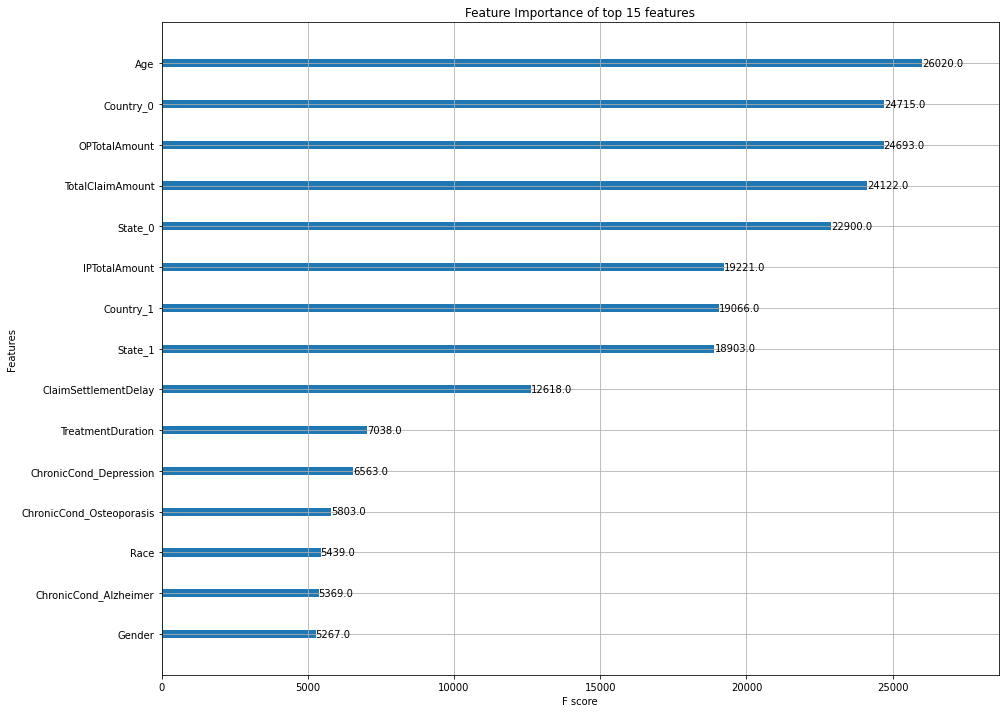

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
xgb.plot_importance(model.named_steps['xgboost'], ax=ax, max_num_features=15,
                    title='Feature Importance of top 15 features')
plt.show()

### Observation

* We can see that the 'Age' of the patient is the most important feature in the classification task, followed by the below features,<br>
&emsp; * 'Country_0': Likelihood probability of the 'Country' feature given non-fraud cases in the Training Dataset.<br>
&emsp; * 'OPTotalAmount': Outpatient Total Amount (Outpatient Annual Reimbursement Amount + Outpatient Annual Deductible Amount).<br>
&emsp; * 'TotalClaimAmount': Total Claim Amount (Insurance Claim Amount Reimbursed + Deductible Amount Paid).<br>
&emsp; * 'State_0': Likelihood probability of the 'State' feature given non-fraud cases in the Training Dataset.<br>.
&emsp; * 'IPTotalAmount': Inpatient Total Amount (Inpatient Annual Amount reimbursed + Inpatient Annual Deductible Amount).<br>
&emsp; * 'Country_1': Likelihood probability of the 'Country' feature given fraud cases in the Training Dataset.<br>
&emsp; * 'State_1': Likelihood probability of the 'State' feature given fraud cases in the Training Dataset.<br>
&emsp; * and so on.
* XGBoost's feature importance take cares about only the global structure of the dataset (training dataset) and remains same for all the query points.
* Lets try to check the model's interpretability based on the Explainable AI (XAI) concepts like LIME and SHAP.
* Unlike XGBoost's Feature Importance, LIME and SHAP are based on the local structures and not global structures.

----

## <font color="blue">3.2. Model Interpretability - LIME</font>

* LIME is an Explainable AI concept that focuses on the local neighborhood of the query points in finding a surrogate function to approximate the original function (XGBoost here).
* The surrogate function is found based on the exponential proximity of the neighbors around the query points.

In [12]:
# Read the Train Dataset used for training the XGBoost with SMOTE oversampling.
xSMOTE = pd.read_csv('Data/xTrainSMOTE.csv')
ySMOTE = pd.read_csv('Data/yTrainSMOTE.csv').squeeze(axis=1)

* As we need to use the original dataset used while training the XGBoost Datapipeline Model, we need to apply the featurization techniques ('Standardization' and 'Response Encoding') on the dataset as it was done before training the XGBoost.
* Normal preprocessed data cannot be used directly in LIME here because LIME doesn't support Datapipeline as of now.
* Hence, do the featurization explicitly on Train and Test data before feeding into LIME. Remember, the sklearn pipeline had already handled it based on the steps.

In [13]:
%%time
# Featurize Train and Test Dataset explicitly.
xSMOTEFE = model.named_steps['standardization'].transform(xSMOTE)
xSMOTEFE = model.named_steps['responseEncoding'].transform(xSMOTEFE)

xTestFE = model.named_steps['standardization'].transform(xTest)
xTestFE = model.named_steps['responseEncoding'].transform(xTestFE)

Wall time: 2.21 s


### <font color="blue">3.2.1. LIME - Datapoint with negative prediction</font>

In [14]:
datapoint = xTest.iloc[0]

In [15]:
# Predict the class of the 1st datapoint in Test Dataset using the XGBoost Model Pipeline
yPred = model.predict(datapoint.to_frame().T)[0]
print('Potential Fraud (1st datapoint):', 'Yes' if yPred == 1 else 'No')

Potential Fraud (1st datapoint): No


In [16]:
%%time
# Define the LimeTabularExplainer Object
explainer = lime_tabular.LimeTabularExplainer(training_data=xSMOTEFE.to_numpy(), feature_names=xSMOTEFE.columns,
                                              class_names=[0, 1], mode='classification')

Wall time: 9.98 s


In [17]:
# Plot the Model Interpretation
exp = explainer.explain_instance(data_row=xTestFE.iloc[0].to_numpy(), predict_fn=model.named_steps['xgboost'].predict_proba)
exp.show_in_notebook(show_table=True)

In [25]:
exp.save_to_file('Reports/LIME.html')

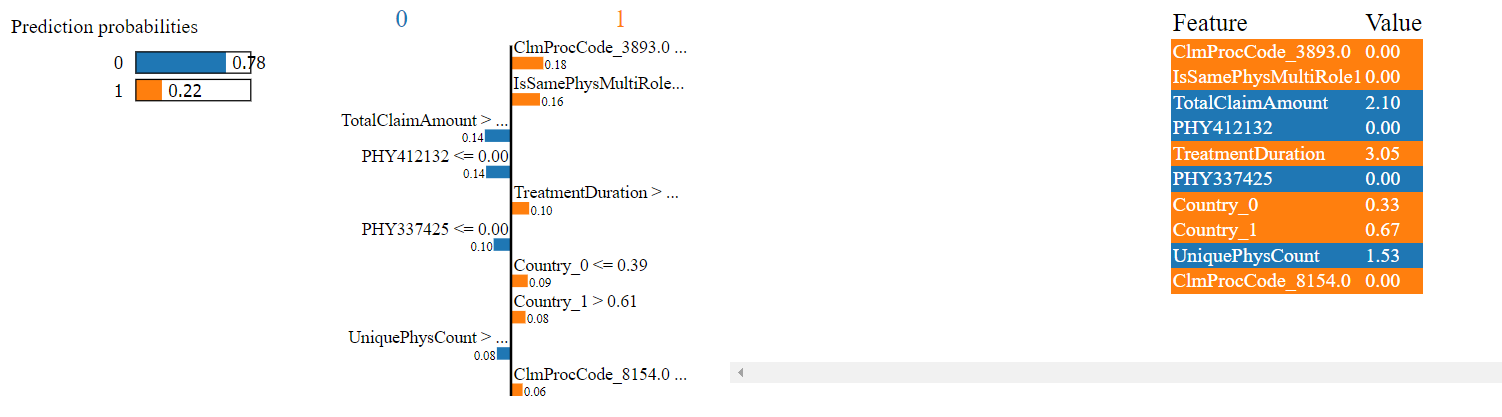

* The Model is 78% confident that the case is a non-fraudulent case.
* The values of 'TotalClaimAmount', 'PHY412132', 'PHY337425', and 'UniquePhysCount' increase the claims chances to be classified as non-fraudulent.
* The values of 'ClmProcCode_3893.0', 'IsSamePhysMultiRole1', 'TreatmentDuration' 'Country_0' (likelihood probability of patient's country given non-fraudulent case in the train dataset), 'Country_1' (likelihood probability of the patient's country given fraudulent case in the train dataset) and 'ClmProcCode_8154.0' decrease the chance a little bit for the claim to be classified as non-fraudulent.

### <font color="blue">3.2.2. LIME - Datapoint with positive prediction</font>

In [26]:
datapoint = xTest.iloc[1]

In [27]:
# Predict the class of the 1st datapoint in Test Dataset using the XGBoost Model Pipeline
yPred = model.predict(datapoint.to_frame().T)[0]
print('Potential Fraud (1st datapoint):', 'Yes' if yPred == 1 else 'No')

Potential Fraud (1st datapoint): Yes


In [28]:
# Plot the Model Interpretation
exp = explainer.explain_instance(data_row=xTestFE.iloc[1].to_numpy(), predict_fn=model.named_steps['xgboost'].predict_proba)
exp.show_in_notebook(show_table=True)

In [29]:
exp.save_to_file('Reports/LIME1.html')

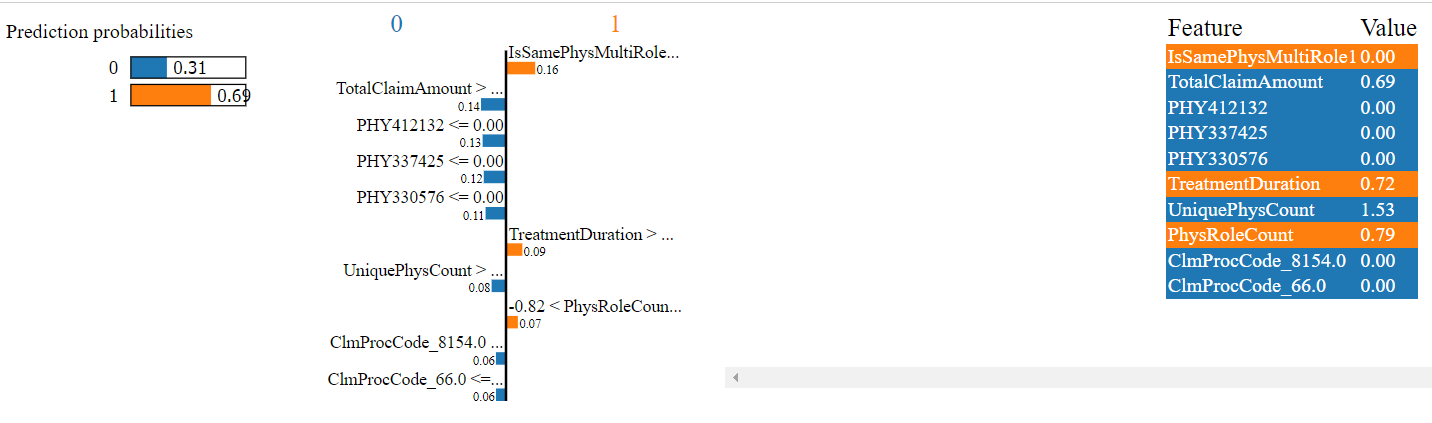

* The Model is 69% confident that the case is a fraudulent case.
* The values of 'IsSamePhysMultiRole1', 'TreatmentDuration', and 'PhysRoleCount' increase the claims chances to be classified as fraudulent.
* The values of 'TotalClaimAmount', presence of the physicians: 'PHY337425', 'PHY330576' and 'PHY412132', presence of Claim Procedure Codes: 'ClmProcCode_8154.0' & 'ClmProcCode_66.0' and 'UniquePhysCount' decrease the chance a bit for the claim to be classified as fraudulent.

----

## <font color="blue">3.3. Model Interpretability - Tree SHAP</font>

* Tree SHAP was found to be consuming too much time in finding the SHAP values.
* Hence, we won't consider explaining the Model using SHAP.

----